In [16]:
%matplotlib inline
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import xesmf as xe
import glac_mw.plotting as plotting
import glac_mw.saving as saving
import glac_mw.spreading as spreading
import glac_mw.glac1d_toolbox as tb

# Demonstration spread algorithm

**Objective** : To avoid high peaks in meltwater distribution here is an alogithm to spread metlwater from collection boxes to spreading regions. This is added to the waterfix to create the final spreaded waterfix file.
- Collect routed meltwater points (m3/s) in collection boxes and distribute them to spreading regions overlaped with the 500m land sea mask (m3/s).
- Convert waterfix (kg/m2/s) to (m3/s). Add waterfix file (with nan replaced by 0) (m3/s).
- Check conservation of flux with a flux check.

*DIRECTLY ADAPTED FROM produce_deglacHadCM3_spread.py by R F Ivanovic*

## Inputs

**Routed mask :** 3 dimensional routed poitnlike meltwater mask (routing algorithm outcome). Because the saving algorithm deal with a flux per surface, we also need to convert the meltwater_discharge *(kg/m2/s -> m3/s)*.

In [7]:
ds_routed = xr.open_dataset('/nfs/annie/eeymr/work/outputs/Proj_GLAC1D/dif_-26_0/teadv3.qrparm.GLAC1D_DEGLAC.nc', decode_times=False)
lon_hadcm3, lat_hadcm3, t_hadcm3, discharge = ds_routed.longitude.values, ds_routed.latitude.values, ds_routed.t.values, ds_routed.discharge
lon_hadcm3_b, lat_hadcm3_b = tb.create_coordinate_edges(lon_hadcm3), tb.create_coordinate_edges(lat_hadcm3)
print(ds_routed)

surface_matrix = tb.surface_matrix(lon_hadcm3, lat_hadcm3)
discharge = np.where(np.isnan(discharge), 0, discharge / 1000 * surface_matrix)

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 261)
Coordinates:
  * t          (t) int64 -26000 -25900 -25800 -25700 -25600 ... -300 -200 -100 0
  * latitude   (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
Data variables:
    discharge  (t, latitude, longitude) float64 ...
Attributes:
    title:    waterfix for transient GLAC1D last delgaciation HadCM3 project ...
    history:  Created 2020-02-13 10:11:43.965702 by Yvan Romé


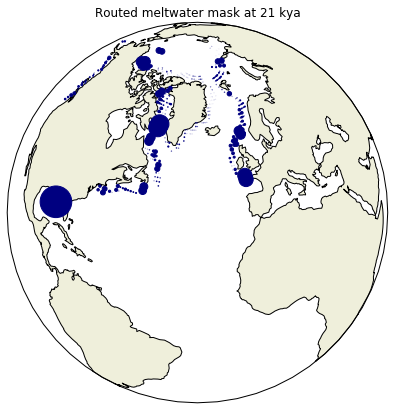

In [8]:
projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)

figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(7,7))

x,y,s = plotting.scatter_mask(discharge[40])
axMap.scatter(lon_hadcm3[x], lat_hadcm3[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axMap.set_global()
axMap.set_title("Routed meltwater mask at 21 kya")
axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

**Land Sea Mask :** Surface and 500m land sea mask.

Text(0.5, 1.0, 'Land sea mask - 500m')

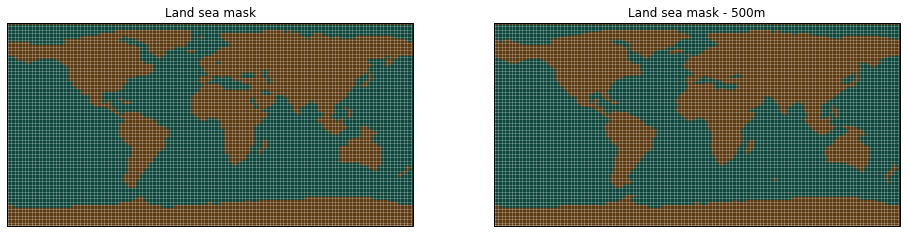

In [9]:
ds_lsm = xr.open_dataset('/nfs/annie/earpal/database/experiments/temev/inidata/temev.qrparm.omask.nc')
lon_lsm, lat_lsm, depth, lsm = ds_lsm.longitude.values, ds_lsm.latitude.values, ds_lsm.depthdepth.values, ds_lsm.lsm.values

masked = np.copy(lsm)  # land mask True (1) on land
depthm = np.ma.masked_less(depth, 500.0)  # mask areas shallower than 500m
masked_500m = np.copy(depthm.mask) + masked  # create binary mask from depth data

projection_map = ccrs.PlateCarree()

figMap,(axMask, ax500) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection':projection_map}, figsize=(16,8))
axMask.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, masked, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axMask.set_title("Land sea mask")
ax500.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, masked_500m, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
ax500.set_title("Land sea mask - 500m")

**Waterfix** : 2 dimenstion (lat*lon) hadcm3 meltwater discharge

In [10]:
ds_wfix = xr.open_dataset('/nfs/annie/earpal/database/experiments/temev/inidata/temev.qrparm.waterfix.nc')

lon_wfix, lat_wfix = ds_wfix.longitude.values, ds_wfix.latitude.values
lon_wfix_b, lat_wfix_b = tb.create_coordinate_edges(lon_wfix), lat_wfix
wfix = ds_wfix.field672.isel(depth=0).isel(t=0)

ds_wfix

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 144, longitude: 290, t: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 358.75 360.0 361.25
  * latitude   (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
  * depth      (depth) float32 5.0
  * t          (t) object 1800-12-01 00:00:00
Data variables:
    field672   (t, depth, latitude, longitude) float32 ...
Attributes:
    history:  Thu Jan 18 08:19:59 GMT 2018 - CONVSH V1.91 16-February-2006

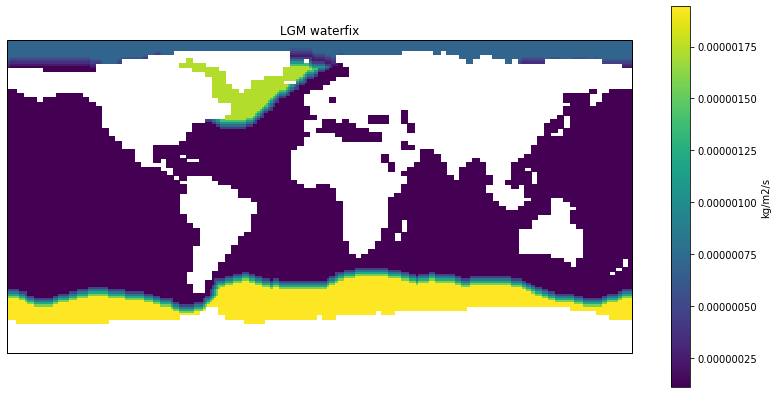

In [11]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

cmap = axMap.pcolormesh(lon_wfix_b, lat_wfix_b, wfix, transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("LGM waterfix")
figMap.colorbar(mappable=cmap, ax=axMap, label="kg/m2/s")

## Spreading algorithm - Main method

In [14]:
discharge_spreaded = spreading.spreading(discharge, ds_lsm, ds_wfix)

__ Spreading algorithm
____ Spreading in {'name': 'US_East_Coast', 'loc': 147 ocean cells in the region, 'region': 125 ocean cells in the region}
____ Spreading in {'name': 'Greenland_Arctic', 'loc': 163 ocean cells in the region, 'region': 163 ocean cells in the region}
____ Spreading in {'name': 'N_American_Arctic', 'loc': 390 ocean cells in the region, 'region': 355 ocean cells in the region}
____ Spreading in {'name': 'Gulf_of_Mexico', 'loc': 96 ocean cells in the region, 'region': 72 ocean cells in the region}
____ Spreading in {'name': 'East_Pacific', 'loc': 292 ocean cells in the region, 'region': 270 ocean cells in the region}
____ Spreading in {'name': 'Russia_Pacific', 'loc': 21 ocean cells in the region, 'region': 12 ocean cells in the region}
____ Spreading in {'name': 'LabradorSea_BaffinBay', 'loc': 228 ocean cells in the region, 'region': 175 ocean cells in the region}
____ Spreading in {'name': 'Atlantic_GreenlandIceland', 'loc': 116 ocean cells in the region, 'region': 

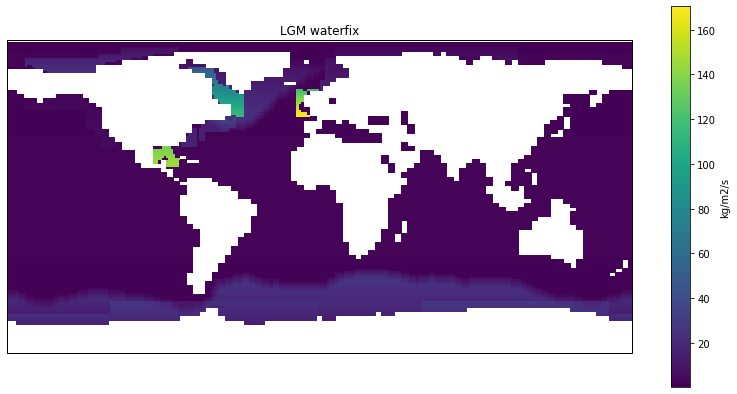

In [17]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, saving.masking_method(spreaded_mw[40], lsm), transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("LGM waterfix")
figMap.colorbar(mappable=cmap, ax=axMap, label="kg/m2/s")

## Collection and spreading zones

We access collection boxes and spreading regions by using spreading methods. Details can be updated by modifying the python file.

In [18]:
cb = spreading.generate_collection_boxes()

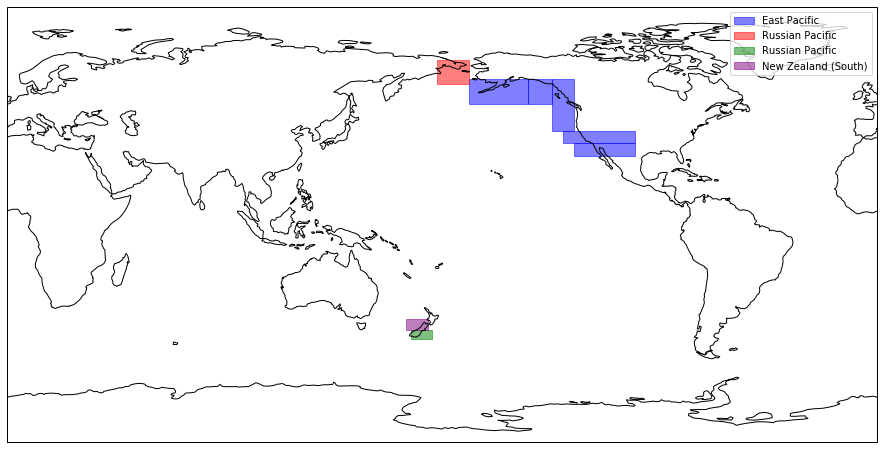

In [33]:
# PACIFIC

projection_map = ccrs.PlateCarree(central_longitude=180.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))

# East Pacific
axMap.fill(cb["EPac1"].cycle_box()[0], cb["EPac1"].cycle_box()[1], 
           color='blue', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="East Pacific")
axMap.fill(cb["EPac2"].cycle_box()[0], cb["EPac2"].cycle_box()[1],
           color='blue', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["EPac3"].cycle_box()[0], cb["EPac3"].cycle_box()[1],
           color='blue', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["EPac4"].cycle_box()[0], cb["EPac4"].cycle_box()[1],
           color='blue', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["EPac5"].cycle_box()[0], cb["EPac5"].cycle_box()[1],
           color='blue', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())

# Russia Pacific
axMap.fill(cb["RussPac1"].cycle_box()[0], cb["RussPac1"].cycle_box()[1], 
           color='red', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Russian Pacific")

# New Zealand (South)
axMap.fill(cb["SNZPac1"].cycle_box()[0], cb["SNZPac1"].cycle_box()[1], 
           color='green', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Russian Pacific")

# New Zealand (North)
axMap.fill(cb["NNZPac1"].cycle_box()[0], cb["NNZPac1"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="New Zealand (South)")

axMap.set_global()
axMap.coastlines()
axMap.legend(loc="upper right")

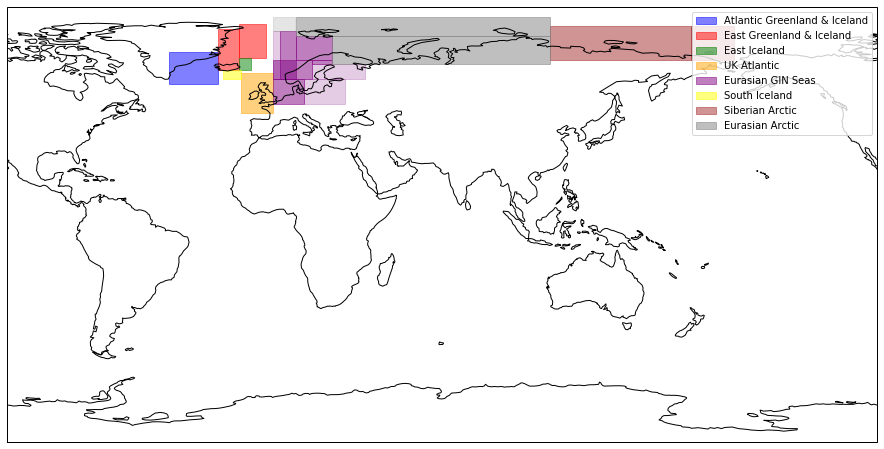

In [34]:
# ARCTIC

projection_map = ccrs.PlateCarree(central_longitude=70.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))

# Atlantic Greenland Iceland
axMap.fill(cb["AtlGr1"].cycle_box()[0], cb["AtlGr1"].cycle_box()[1], 
           color='blue', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Atlantic Greenland & Iceland")

# E Greenland & Iceland
axMap.fill(cb["EGrIce1"].cycle_box()[0], cb["EGrIce1"].cycle_box()[1], 
           color='red', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="East Greenland & Iceland")
axMap.fill(cb["EGrIce2"].cycle_box()[0], cb["EGrIce2"].cycle_box()[1], 
           color='red', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())

# E Iceland
axMap.fill(cb["EIceland1"].cycle_box()[0], cb["EIceland1"].cycle_box()[1], 
           color='green', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="East Iceland")

# UK Atlantic
axMap.fill(cb["UKAtl1"].cycle_box()[0], cb["UKAtl1"].cycle_box()[1], 
           color='orange', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="UK Atlantic")

# Eurasian GIN Seas
axMap.fill(cb["EurGIN1"].cycle_box()[0], cb["EurGIN1"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Eurasian GIN Seas")
axMap.fill(cb["EurGIN2"].cycle_box()[0], cb["EurGIN2"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["EurGIN3"].cycle_box()[0], cb["EurGIN3"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["EurGIN4"].cycle_box()[0], cb["EurGIN4"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["EurGIN5"].cycle_box()[0], cb["EurGIN5"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["EurGIN6"].cycle_box()[0], cb["EurGIN6"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())
axMap.fill(cb["Baltic1"].cycle_box()[0], cb["Baltic1"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())
axMap.fill(cb["Baltic2"].cycle_box()[0], cb["Baltic2"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())

# South Iceland
axMap.fill(cb["SIceland1"].cycle_box()[0], cb["SIceland1"].cycle_box()[1], 
           color='yellow', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="South Iceland")

# Siberian Arctic
axMap.fill(cb["SibArc1"].cycle_box()[0], cb["SibArc1"].cycle_box()[1], 
           color='brown', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Siberian Arctic")
axMap.fill(cb["SibArc2"].cycle_box()[0], cb["SibArc2"].cycle_box()[1], 
           color='brown', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())

# Eurasian Arctic
axMap.fill(cb["EurArc1"].cycle_box()[0], cb["EurArc1"].cycle_box()[1], 
           color='grey', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Eurasian Arctic")
axMap.fill(cb["EurArc2"].cycle_box()[0], cb["EurArc2"].cycle_box()[1], 
           color='grey', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["EurArc3"].cycle_box()[0], cb["EurArc3"].cycle_box()[1], 
           color='grey', linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())

axMap.set_global()
axMap.coastlines()
axMap.legend(loc="upper right")

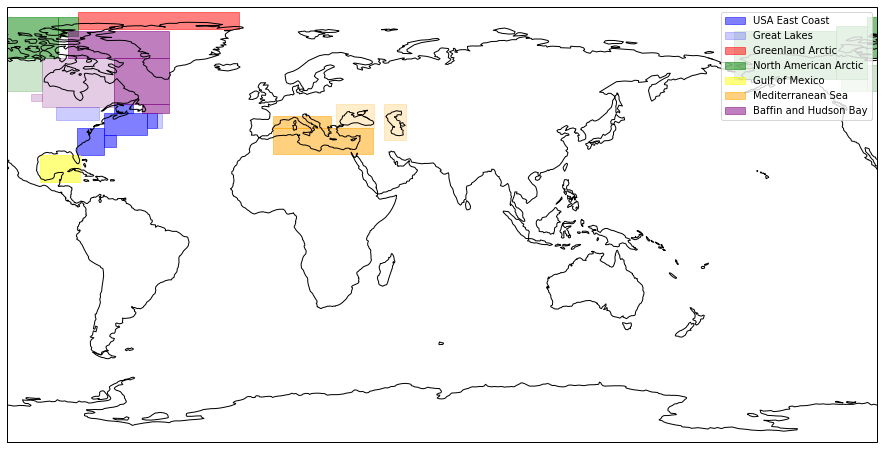

In [35]:
projection_map = ccrs.PlateCarree(central_longitude=70.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))

## NORTH ATLANTIC

# USA East Coast
axMap.fill(cb["USECoast1"].cycle_box()[0], cb["USECoast1"].cycle_box()[1], 
           color='blue', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="USA East Coast")
axMap.fill(cb["USECoast2"].cycle_box()[0], cb["USECoast2"].cycle_box()[1], 
           color='blue', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["USECoast3"].cycle_box()[0], cb["USECoast3"].cycle_box()[1], 
           color='blue', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["USECoast4"].cycle_box()[0], cb["USECoast4"].cycle_box()[1], 
           color='blue', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["USECoast5"].cycle_box()[0], cb["USECoast5"].cycle_box()[1], 
           color='blue', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["USECoast6"].cycle_box()[0], cb["USECoast6"].cycle_box()[1], 
           color='blue', linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())
axMap.fill(cb["GrLakes1"].cycle_box()[0], cb["GrLakes1"].cycle_box()[1], 
           color='blue', linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree(), label="Great Lakes")


# Greenland Arctic
axMap.fill(cb["GrArc1"].cycle_box()[0], cb["GrArc1"].cycle_box()[1], 
           color='red', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Greenland Arctic")

# North American Arctic
axMap.fill(cb["NAMArc1"].cycle_box()[0], cb["NAMArc1"].cycle_box()[1], 
           color='green', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="North American Arctic")
axMap.fill(cb["NAMArc2"].cycle_box()[0], cb["NAMArc2"].cycle_box()[1], 
           color='green', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["NAMArc3"].cycle_box()[0], cb["NAMArc3"].cycle_box()[1], 
           color='green', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["NAMArc4"].cycle_box()[0], cb["NAMArc4"].cycle_box()[1], 
           color='green', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["NAMArc5"].cycle_box()[0], cb["NAMArc5"].cycle_box()[1], 
           color='green', linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())
axMap.fill(cb["NWTerr1"].cycle_box()[0], cb["NWTerr1"].cycle_box()[1], 
           color='green', linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())
axMap.fill(cb["NWTerr2"].cycle_box()[0], cb["NWTerr2"].cycle_box()[1], 
           color='green', linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())

# Gulf of Mexico
axMap.fill(cb["GoM1"].cycle_box()[0], cb["GoM1"].cycle_box()[1], 
           color='yellow', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Gulf of Mexico")

# Mediterranean
axMap.fill(cb["Med1"].cycle_box()[0], cb["Med1"].cycle_box()[1], 
           color='orange', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Mediterranean Sea")
axMap.fill(cb["Med2"].cycle_box()[0], cb["Med2"].cycle_box()[1], 
           color='orange', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["BlckSea1"].cycle_box()[0], cb["BlckSea1"].cycle_box()[1], 
           color='orange', linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())
axMap.fill(cb["CaspSea1"].cycle_box()[0], cb["CaspSea1"].cycle_box()[1], 
           color='orange', linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())

# Labrador Sea & Baffin Bay
axMap.fill(cb["BafLab1"].cycle_box()[0], cb["BafLab1"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Baffin and Hudson Bay")
axMap.fill(cb["BafLab2"].cycle_box()[0], cb["BafLab2"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["BafLab3"].cycle_box()[0], cb["BafLab3"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["HudBay1"].cycle_box()[0], cb["HudBay1"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())
axMap.fill(cb["HudBay2"].cycle_box()[0], cb["HudBay2"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())

axMap.set_global()
axMap.coastlines()
axMap.legend(loc="upper right")

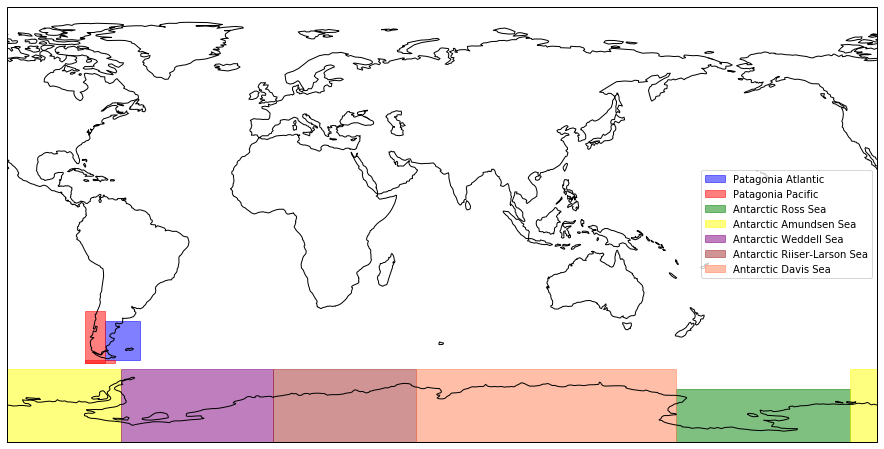

In [36]:
projection_map = ccrs.PlateCarree(central_longitude=70.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))

## ANTARCTICA


# Patagonia Atlantic
axMap.fill(cb["PatAtl1"].cycle_box()[0], cb["PatAtl1"].cycle_box()[1], 
           color='blue', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Patagonia Atlantic")

# Patagonia Pacific
axMap.fill(cb["PatPac1"].cycle_box()[0], cb["PatPac1"].cycle_box()[1], 
           color='red', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Patagonia Pacific")
axMap.fill(cb["PatPac2"].cycle_box()[0], cb["PatPac2"].cycle_box()[1], 
           color='red', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())

# Antarctic Ross Sea
axMap.fill(cb["AARos1"].cycle_box()[0], cb["AARos1"].cycle_box()[1], 
           color='green', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Ross Sea")

# Antarctic Amundsen Sea
axMap.fill(cb["AAAmund"].cycle_box()[0], cb["AAAmund"].cycle_box()[1], 
           color='yellow', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Amundsen Sea")

# Antarctic Weddell Sea
axMap.fill(cb["AAWeddell"].cycle_box()[0], cb["AAWeddell"].cycle_box()[1], 
           color='purple', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Weddell Sea")

# Antarctic Riiser-Larson Sea
axMap.fill(cb["AARiiLar"].cycle_box()[0], cb["AARiiLar"].cycle_box()[1], 
           color='brown', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Riiser-Larson Sea")

# Antarctic Davis Sea
axMap.fill(cb["AADavis"].cycle_box()[0], cb["AADavis"].cycle_box()[1], 
           color='coral', linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Davis Sea")

axMap.set_global()
axMap.coastlines()
axMap.legend(loc="center right")